<a href="https://colab.research.google.com/github/terry-chongkalok/anatomy_of_joke/blob/main/Anatomy_of_Jokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anatomy of Jokes**

Fine-tuning Language Model by `LoRA` for Joke Detection + Detection Explained by `SHAP`
---
`Explaining a joke is like dissecting a frog. You understand it better but the frog dies in the process.🐸`

In [ ]:
!pip install peft
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 18.2 MB/s eta 0:00:00


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict, set_peft_model_state_dict

from sklearn.metrics import f1_score, classification_report, confusion_matrix

import shap

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
batch_size = 64
num_epochs = 1
lr = 3e-4

model_name = "distilroberta-base"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


## 1. Data Loading and Cleansing

In [ ]:
source_file_path = 'https://github.com/Moradnejad/ColBERT-Using-BERT-Sentence-Embedding-for-Humor-Detection/raw/master/Data/dataset.csv'
humor_df = pd.read_csv(source_file_path)
print(f"Table size: {humor_df.shape}")

with pd.option_context('display.max_colwidth', None):
  display(humor_df.head())

Table size: (200000, 2)


,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not running'",False
1,Watch: darvish gave hitter whiplash with slow pitch,False
2,What do you call a turtle without its shell? dead.,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind, new autopsy shows",False


In [ ]:
print("Number of NA:")
print(humor_df.isna().sum())

print("\nNumber of Data for each class:")
print(humor_df['humor'].value_counts())

Number of NA:
text     0
humor    0
dtype: int64

Number of Data for each class:
False    100000
True     100000
Name: humor, dtype: int64


In [ ]:
text_clean_dict = {
          ':\(':'',
          '!': '.',
          '\*': '',
          '💯': 'good.'
}

In [ ]:
humor_df['text'] = humor_df['text'].replace(text_clean_dict, regex=True).str.strip()

In [ ]:
def fill_full_stop(txt: str):
  last_chr = '' if len(txt) < 1 else txt[-1]

  if last_chr.isalpha() or last_chr.isdigit():
    return txt + '.'

  return txt

In [ ]:
humor_df['text'] = humor_df['text'].apply(fill_full_stop)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='right')

In [ ]:
humor_df['token_len'] = humor_df['text'].apply(lambda x: sum(tokenizer(x, padding='max_length', truncation=True, max_length=None)['attention_mask']))

In [ ]:
print("Stat of Token Length -- \n\nJokes:")
display(humor_df.query("humor==True")[['token_len']].describe())
print("\nNon Jokes:")
display(humor_df.query("humor==False")[['token_len']].describe())

Stat of Token Length -- 

Jokes:


,token_len
count,100000.000000
mean,19.564990
std,3.690086
min,10.000000
25%,17.000000
50%,19.000000
75%,22.000000
max,67.000000



Non Jokes:


,token_len
count,100000.00000
mean,17.43711
std,3.68561
min,10.00000
25%,15.00000
50%,17.00000
75%,20.00000
max,82.00000


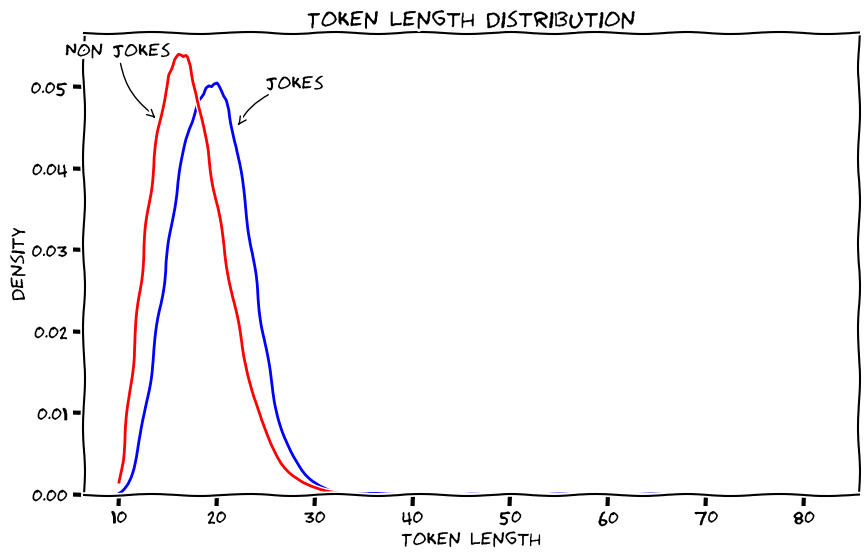

In [ ]:
with plt.xkcd():
  plt.rcParams['font.family'] = ['Humor Sans']
  plt.rcParams["figure.figsize"] = (10,6)

  fig, ax = plt.subplots()
  sns.kdeplot(data=humor_df, x='token_len', hue='humor',
              bw_adjust=1.5, cut=0,
              palette=["red", 'blue'], ax=ax, legend=False)

  arrowprops_dict = {'arrowstyle': '->', 'connectionstyle': 'arc3, rad=0.2'}
  ax.annotate('Jokes', xy=(22, 0.045), xytext=(25, 0.05), arrowprops=arrowprops_dict)
  ax.annotate('Non Jokes', xy=(14, 0.046), xytext=(4.5, 0.054), arrowprops=arrowprops_dict)

  ax.set_xlabel('Token Length')
  ax.set_title('Token Length Distribution')
  plt.show()

In [ ]:
class HumorDS(Dataset):
  def __init__(self, df=humor_df, tokenizer=tokenizer):
    self.df = df
    self.tokenizer = tokenizer

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, ind):
    word_seq = self.tokenizer(self.df["text"][ind], padding='max_length', truncation=True, max_length=128)
    return {"input_ids": torch.tensor(word_seq['input_ids']), "labels": torch.tensor(self.df['humor'][ind] + 0)}

In [ ]:
humor_ds = HumorDS()

In [ ]:
train_val_split_size = (len(humor_ds) - 1000, 1000)
train_val_ds, test_ds = random_split(humor_ds, train_val_split_size)

train_val_split_size = (len(train_val_ds) - 1000, 1000)
train_ds, val_ds = random_split(train_val_ds, train_val_split_size)

In [ ]:
print(f"Training data size: {len(train_ds)}")
print(f"Validation data size: {len(val_ds)}")
print(f"Testing data size: {len(test_ds)}")

Training data size: 198000
Validation data size: 1000
Testing data size: 1000


In [ ]:
def collate_fn(data):
    return tokenizer.pad(data, padding="longest", return_tensors="pt")

In [ ]:
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)

## 2. Downloading Existing Language Model and Create Adapter

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=humor_df['humor'].nunique(), return_dict=True) # if regression instead of classification needed, set `num_labels` = 1 or `problem_type` = 'regression'
model = get_peft_model(model, peft_config)
print('\n')
model.print_trainable_parameters()
print('\n')
model.to(device)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bia



trainable params: 1331716 || all params: 82859524 || trainable%: 1.6071972607518237




PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-5): 6 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (d

In [ ]:
def eval_f1(loader=val_loader, model=model, print_details=False):
  model.eval()
  all_preds = []
  all_actual = []
  for batch in loader:
    batch.to(device)
    outputs = model(**batch)
    predictions = outputs.logits.argmax(dim=-1)
    all_actual += batch["labels"].cpu().tolist()
    all_preds += predictions.detach().cpu().tolist()

  eval_metric = f1_score(all_actual, all_preds, zero_division=0)
  if print_details:
    print(classification_report(y_true=all_actual, y_pred=all_preds, zero_division=0))
    print(confusion_matrix(y_true=all_actual, y_pred=all_preds))
    print(f"\nF1 Score: {eval_metric}")
  return eval_metric

In [ ]:
# model performance before any fine-tuning
_ = eval_f1(print_details=True)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


              precision    recall  f1-score   support

           0       0.50      1.00      0.66       496
           1       0.00      0.00      0.00       504

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000

[[496   0]
 [504   0]]

F1 Score: 0.0


## 3. Adapter Training

In [ ]:
optimizer = AdamW(params=model.parameters(), lr=lr)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_loader) * num_epochs),
    num_training_steps=(len(train_loader) * num_epochs),
)

In [ ]:
for epoch in range(num_epochs):
  for step, batch in enumerate(tqdm(train_loader)):
    model.train()
    batch.to(device)
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

    if not((step + 1) % 400):
      print(f"\nF1 Score after step {step + 1}:", eval_f1(), '\n')

 13%|█▎        | 400/3094 [03:15<1:17:09,  1.72s/it]


F1 Score after step 400: 0.9734513274336283 



 26%|██▌       | 800/3094 [06:40<1:05:32,  1.71s/it]


F1 Score after step 800: 0.973240832507433 



 39%|███▉      | 1200/3094 [10:06<55:27,  1.76s/it]


F1 Score after step 1200: 0.9742063492063492 



 52%|█████▏    | 1600/3094 [13:31<43:54,  1.76s/it]


F1 Score after step 1600: 0.9770687936191426 



 65%|██████▍   | 2000/3094 [16:56<31:23,  1.72s/it]


F1 Score after step 2000: 0.978978978978979 



 78%|███████▊  | 2400/3094 [20:22<19:54,  1.72s/it]


F1 Score after step 2400: 0.9772502472799208 



 90%|█████████ | 2800/3094 [23:47<08:25,  1.72s/it]


F1 Score after step 2800: 0.9779999999999999 



100%|██████████| 3094/3094 [26:14<00:00,  1.96it/s]


## 4. Model Evaluation and Prediction Explanation

In [ ]:
val_f1 = eval_f1(print_details=True)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       496
           1       0.98      0.97      0.98       504

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

[[488   8]
 [ 13 491]]

F1 Score: 0.9790628115653041


In [ ]:
def pred_prob(txt_list: list, model=model, tokenizer=tokenizer):
  seq_tensor = torch.tensor([tokenizer(txt, padding='max_length', truncation=True, max_length=128)['input_ids'] for txt in txt_list]).to(device)
  model.eval()
  pred = model(seq_tensor).logits
  return torch.softmax(pred, -1).detach().cpu().numpy()

In [ ]:
explainer = shap.Explainer(pred_prob, tokenizer)

In [ ]:
def pred_with_shap(txt: str, explainer=explainer):
  print("It is a joke.🤣" if pred_prob([txt]).argmax() else "It is not a joke.🥱")
  shap_values = explainer([txt])
  shap.plots.text(shap_values)

In [ ]:
pred_with_shap("What a great movie.")

It is not a joke.🥱


In [ ]:
pred_with_shap("What a great movie...if you have no taste.")

It is a joke.🤣


In [ ]:
pred_with_shap("The Transformer architecture revolutionized the use of attention by dispensing with recurrence and convolutions.")

It is not a joke.🥱


In [ ]:
# without full stop
pred_with_shap("The Transformer architecture revolutionized the use of attention by dispensing with recurrence and convolutions")

It is not a joke.🥱


In [ ]:
pred_with_shap("I wish I could see what it was like to be fat for just one day, I'm tired of being fat every day.")

It is a joke.🤣


In [ ]:
pred_with_shap("Tom failed math so many times. He can't even count.")

It is a joke.🤣


In [ ]:
# failed detection
pred_with_shap("The student failed math so many times, he can't even count.")

It is not a joke.🥱


In [ ]:
# another failed detection
pred_with_shap("Feel free to contact me if you have any questions.")

It is a joke.🤣


📋 **Obeservations:**

In most cases the SHAP Explainer successfully identified the punch words in jokes with a positive contribution to the joke detection.

However, the explanation results also revealed that there is still room for improvement in the detection model:

1. The contribution of the punch words to the classification score was not always the largest compared to other words in the jokes.

2. Pronouns like "I" and "me" often had high contributions to joke detection, which sometimes led to false positive detections, as seen in the last example.

3. When comparing the base value for sentences of different lengths, it was observed that the detection model generally predicted a higher probability for longer sentences, which suggests a possible bias.


Data-centric suggestions to improve the detection and explainability:
1. Collect more diverse data from different sources, eg including more non joke text containing pronouns, longer non joke text, or shorter joke text.

2. Create negative sample data by changing the punch words in a joke to make it unfunny, which would help the model and SHAP explainer better understand the importance of the punch words. (This can be done on a large scale with the help of ChatGPT.)

In [ ]:
test_f1 = eval_f1(loader=test_loader, print_details=True)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       504
           1       0.98      0.98      0.98       496

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

[[494  10]
 [ 12 484]]

F1 Score: 0.9777777777777779


## 5. Save and Load Adapter

In [ ]:
peft_adapter_dir = 'joke_detector'

In [ ]:
model.save_pretrained(peft_adapter_dir)

In [ ]:
pretrained_peft_config = LoraConfig.from_pretrained(peft_adapter_dir)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=humor_df['humor'].nunique(), return_dict=True)
model = get_peft_model(model, pretrained_peft_config)
model.to(device)

print("\nPrediction WITHOUT the pretrained adapter:")
pred_prob(["How are you?"], model=model)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bia


Prediction WITHOUT the pretrained adapter:


array([[0.5159784, 0.4840216]], dtype=float32)

In [ ]:
adapter_weights = torch.load(peft_adapter_dir + '/adapter_model.bin', map_location=device)
set_peft_model_state_dict(model, adapter_weights)

print("Prediction WITH the pretrained adapter:")
pred_prob(["How are you?"], model=model)

Prediction WITH the pretrained adapter:


array([[0.950097  , 0.04990297]], dtype=float32)